### Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

In [3]:
from dotenv import load_dotenv
import os
from utils.EDA import analysis_임신성공여부, vis_numeric_corr_matrix
load_dotenv()
df_train = pd.read_csv(os.getenv('TRAIN_DATA_PATH')).drop(columns=['ID'])
df_test = pd.read_csv(os.getenv('TEST_DATA_PATH')).drop(columns=['ID'])

df_train.head(8).to_csv('train_sample.csv', encoding = 'utf-8-sig', index = False)

# df_train = pd.read_csv('data/train.csv').drop(columns=['ID'])
# df_test = pd.read_csv('data/test.csv').drop(columns=['ID'])

### Preprocessing

#### 컬럼 제거

In [4]:
# # 결측 비율 80% 이상 제거
# missing_ratio = df_train.isnull().mean()
# column_missing = missing_ratio[missing_ratio >= 0.8].index.tolist()

# # nunique = 1 제거 
# unique_counts = df_train.nunique()
# column_nunique = unique_counts[unique_counts == 1].index.tolist()

# # 컬럼 제거
# dropped_columns = list(set(column_missing + column_nunique + ['배란 유도 유형']))

# df_train = df_train.drop(columns=dropped_columns)
# df_test = df_test.drop(columns=dropped_columns)

# print("제거된 컬럼 개수:", len(dropped_columns))
# print("제거된 컬럼:", dropped_columns)
# print("df_train.shape:", df_train.shape)
# print("df_test.shape:", df_test.shape)
df_train = df_train.drop('불임 원인 - 여성 요인',axis=1)
df_test = df_test.drop('불임 원인 - 여성 요인',axis=1)

In [5]:
df_train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형',
       '배란 자극 여부', '배란 유도 유형', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부',
       '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인',
       '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증',
       '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성',
       '불임 원인 - 정자 형태', '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수',
       'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수',
       'DI 출산 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 채취 경과일', '난자 해동 

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 67 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술 시기 코드               256351 non-null  object 
 1   시술 당시 나이               256351 non-null  object 
 2   임신 시도 또는 마지막 임신 경과 연수  9370 non-null    float64
 3   시술 유형                  256351 non-null  object 
 4   특정 시술 유형               256349 non-null  object 
 5   배란 자극 여부               256351 non-null  int64  
 6   배란 유도 유형               256351 non-null  object 
 7   단일 배아 이식 여부            250060 non-null  float64
 8   착상 전 유전 검사 사용 여부       2718 non-null    float64
 9   착상 전 유전 진단 사용 여부       250060 non-null  float64
 10  남성 주 불임 원인             256351 non-null  int64  
 11  남성 부 불임 원인             256351 non-null  int64  
 12  여성 주 불임 원인             256351 non-null  int64  
 13  여성 부 불임 원인             256351 non-null  int64  
 14  부부 주 불임 원인             256351 non-nu

#### astype(int)

In [7]:
# '횟수'를 포함하는 컬럼 찾기
count_columns = [col for col in df_train.columns if '횟수' in col]

def extract_number(value):
    if isinstance(value, str):
        return int(value[0])  # 맨 앞자리 숫자로 변환
    return value

for col in count_columns:
    df_train[col] = df_train[col].apply(extract_number).astype(int)
    df_test[col] = df_test[col].apply(extract_number).astype(int)
print("변환된 컬럼:", count_columns)

변환된 컬럼: ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수']


####  총 시술 횟수 재정의

In [8]:
# 총 시술 횟수 재정의
def update_total_counts(df):
    df['총 시술 횟수'] = df['IVF 시술 횟수'] + df['DI 시술 횟수']
    df['총 임신 횟수'] = df['IVF 임신 횟수'] + df['DI 임신 횟수']
    df['총 출산 횟수'] = df['IVF 출산 횟수'] + df['DI 출산 횟수']
    return df

df_train = update_total_counts(df_train)
df_test = update_total_counts(df_test)

#### 특정 시술 유형 - ICSI / 배아 생성 주요 이유 - 현재 시술용

In [9]:
def get_dummies(df):
    # 특정 시술 유형 - ICSI
    df['특정 시술 유형 - ICSI'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
                             np.where(df['특정 시술 유형'].str.contains('ICSI', na=False), 1, 0))
    
#     # 배아 생성 주요 이유 - 현재 시술용
#     df['배아 생성 주요 이유 - 현재 시술용'] = np.where(df['시술 유형'] != 'IVF', np.nan,  # 시술 유형이 DI
#                              np.where(df['배아 생성 주요 이유'].str.contains('현재 시술용', na=False), 2, 1))

    df = df.drop(columns=['특정 시술 유형', '배아 생성 주요 이유'])
    
    return df

df_train = get_dummies(df_train)
df_test = get_dummies(df_test)

#### 남성/여성/부부 주/부 불임 원인 제거

In [10]:
def drop_cols(df):
    cols = ['남성 주 불임 원인', '남성 부 불임 원인', 
            '여성 주 불임 원인', '여성 부 불임 원인',
            '부부 주 불임 원인', '부부 부 불임 원인']
    
    df = df.drop(columns=cols, errors='ignore')

    return df

df_train = drop_cols(df_train)
df_test = drop_cols(df_test)

#### 난자 혼합 경과일, 배아 이식 경과일 groupby median fillna

In [11]:
def fill_nan(df_train, df_test):
    value1 = 0
    value2 = df_train[df_train['시술 유형'] == 'IVF'].groupby(['신선 배아 사용 여부', '총 생성 배아 수'])['배아 이식 경과일'].median().fillna(5)

    for df in [df_train, df_test]:
        df.loc[df['시술 유형'] == 'IVF', '난자 혼합 경과일'] = df.loc[df['시술 유형'] == 'IVF', '난자 혼합 경과일'].fillna(value1)
        df.loc[df['시술 유형'] == 'IVF', '배아 이식 경과일'] = df[df['시술 유형'] == 'IVF'].apply(
            lambda row: value2.get((row['신선 배아 사용 여부'], row['총 생성 배아 수']), 5) 
            if pd.isna(row['배아 이식 경과일']) else row['배아 이식 경과일'], axis=1
        )

    return df_train, df_test

df_train, df_test = fill_nan(df_train, df_test)

### Feature engineering

In [12]:
def feature_engineering(df):
    epsilon = 1e-5
    
    # 임신/출산 성공률
    df['IVF 시술 대비 임신 성공률'] = df['IVF 임신 횟수'] / df['IVF 시술 횟수']
    # df['IVF 임신 대비 출산 성공률'] = df['IVF 출산 횟수'] / df['IVF 임신 횟수']
    # df['총 임신 대비 출산 성공률'] = df['총 출산 횟수'] / df['총 임신 횟수']
    # df['총 임신 대비 출산 실패율'] = 1 - df['총 임신 대비 출산 성공률']
    
    # 난자
    df['총 난자 수'] = df['수집된 신선 난자 수'] + df['해동 난자 수']
    df['난자 사용률'] = df['혼합된 난자 수'] / df['총 난자 수']
    
    # 배아
    df['총 배아 수'] = df['총 생성 배아 수'] + df['해동된 배아 수']
    df['미세주입 배아 생성 확률'] = df['미세주입에서 생성된 배아 수'] / df['미세주입된 난자 수']
    df['미세주입 배아 이식 확률'] = df['미세주입 배아 이식 수'] / df['미세주입에서 생성된 배아 수']
    df['총 배아 생성 확률'] = df['총 배아 수'] / df['총 난자 수']
    df['신선 + 기증 + 동결'] = df[['신선 배아 사용 여부', '기증 배아 사용 여부', '동결 배아 사용 여부']].sum(axis=1)
    df['배아 저장 비율'] = df['저장된 배아 수'] / (df['총 생성 배아 수'] + epsilon)
    
    # 이식된 배아 수 관련
    df['배아 이식 대비 임신 성공률'] = df['총 임신 횟수'] / df['이식된 배아 수']
    df['배아 이식 대비 출산 성공률'] = df['총 출산 횟수'] / df['이식된 배아 수']
    df['배아 이식 확률'] = df['이식된 배아 수'] / df['총 배아 수']
    df['이식된 배아 대비 이식 기간'] = df['배아 이식 경과일'] / df['이식된 배아 수']
#     df.loc[df['배아 이식 경과일'] == 0, '이식된 배아 대비 이식 기간'] = 0
    # df['혼합된 난자 수 대비 이식된 배아 수'] =  df['이식된 배아 수'] / df['혼합된 난자 수']
    # df.loc[df['이식된 배아 수'] == 0, '혼합된 난자 수 대비 이식된 배아 수'] = 0
    
    # 나이
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 생성 배아 수'] = df.groupby('시술 당시 나이')['총 배아 수'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 이식 배아 수'] = df.groupby('시술 당시 나이')['이식된 배아 수'].transform('mean')
    # df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 이식 경과일'] = df.groupby('시술 당시 나이')['배아 이식 경과일'].transform('mean')

    # 기타
    df['배란자극 * 단일이식'] = df['배란 자극 여부'] * df['단일 배아 이식 여부']
    df['배란자극 * ICSI'] = df['배란 자극 여부'] * df['특정 시술 유형 - ICSI'] 
    df['경과일 차이'] = np.abs(df['배아 이식 경과일'] - df['난자 혼합 경과일'])
    
    # 바이너리 합
    binary_cols = [
        '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 진단 사용 여부',
        '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부'
    ]
    df['바이너리 합'] = df[binary_cols].sum(axis=1)
    
    # 불임 원인 점수
    infertility_cols = [
        '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인',
        '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증',
        '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인',
        '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태'
    ]
    for col in infertility_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Y': 1, 'N': 0})
    df['불임원인 수'] = df[infertility_cols].sum(axis=1)
    
    # 변수 제거
    cols = ['총 난자 수']
    df = df.drop(columns=cols, errors='ignore')
    # rare_columns = ['불임 원인 - 자궁경부 문제', '불임 원인 - 정자 농도', 
    #             '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 형태', '불임 원인 - 정자 운동성']
    # # df['Rare_Feature_Sum'] = df[rare_columns].sum(axis=1)
    # df = df.drop(columns=rare_columns)

    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

#### 시술 유형이 DI인 경우 -1로 채우기

In [13]:
def di_null(df):
    df.loc[df['시술 유형'] == 'DI'] = df.loc[df['시술 유형'] == 'DI'].fillna(-1)
    return df

df_train = di_null(df_train)
df_test = di_null(df_test)

In [14]:
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)

시술 시기 코드                  0.000000
시술 당시 나이                  0.000000
임신 시도 또는 마지막 임신 경과 연수    94.008995
시술 유형                     0.000000
배란 자극 여부                  0.000000
                           ...    
배란자극 * 단일이식               0.000000
배란자극 * ICSI               0.000000
경과일 차이                    0.000000
바이너리 합                    0.000000
불임원인 수                    0.000000
Length: 79, dtype: float64


#### NaN, inf 처리

In [15]:
# 결측값 대체
def replace_inf_and_nan(df, value_inf, value_na):
    df.replace([np.inf, -np.inf], value_inf, inplace=True)  # inf, -inf 변환
    df.fillna(value_na, inplace=True)  # NaN 변환
    return df

# 변환 적용
value_inf = 999 # 3 / 0
value_na = 999 # 0 / 0
df_train = replace_inf_and_nan(df_train, value_inf, value_na)
df_test = replace_inf_and_nan(df_test, value_inf, value_na)

#### Encoding

In [16]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
cat_features

['시술 시기 코드',
 '시술 당시 나이',
 '시술 유형',
 '배란 유도 유형',
 '난자 출처',
 '정자 출처',
 '난자 기증자 나이',
 '정자 기증자 나이']

In [17]:
# LabelEncoder 적용
for col in cat_features:
    le = LabelEncoder() 
    df_train[col] = le.fit_transform(df_train[col])  
    df_test[col] = le.transform(df_test[col]) 

In [18]:
abs(df_train.corr()['임신 성공 여부']).sort_values(ascending=False)

임신 성공 여부              1.000000
배아 이식 대비 임신 성공률       0.239867
배아 이식 대비 출산 성공률       0.239861
이식된 배아 대비 이식 기간       0.239224
경과일 차이                0.176005
                        ...   
불임 원인 - 정자 형태         0.001866
불명확 불임 원인             0.001473
불임 원인 - 정자 면역학적 요인    0.001166
불임 원인 - 정자 농도         0.000626
불임 원인 - 난관 질환         0.000544
Name: 임신 성공 여부, Length: 79, dtype: float64

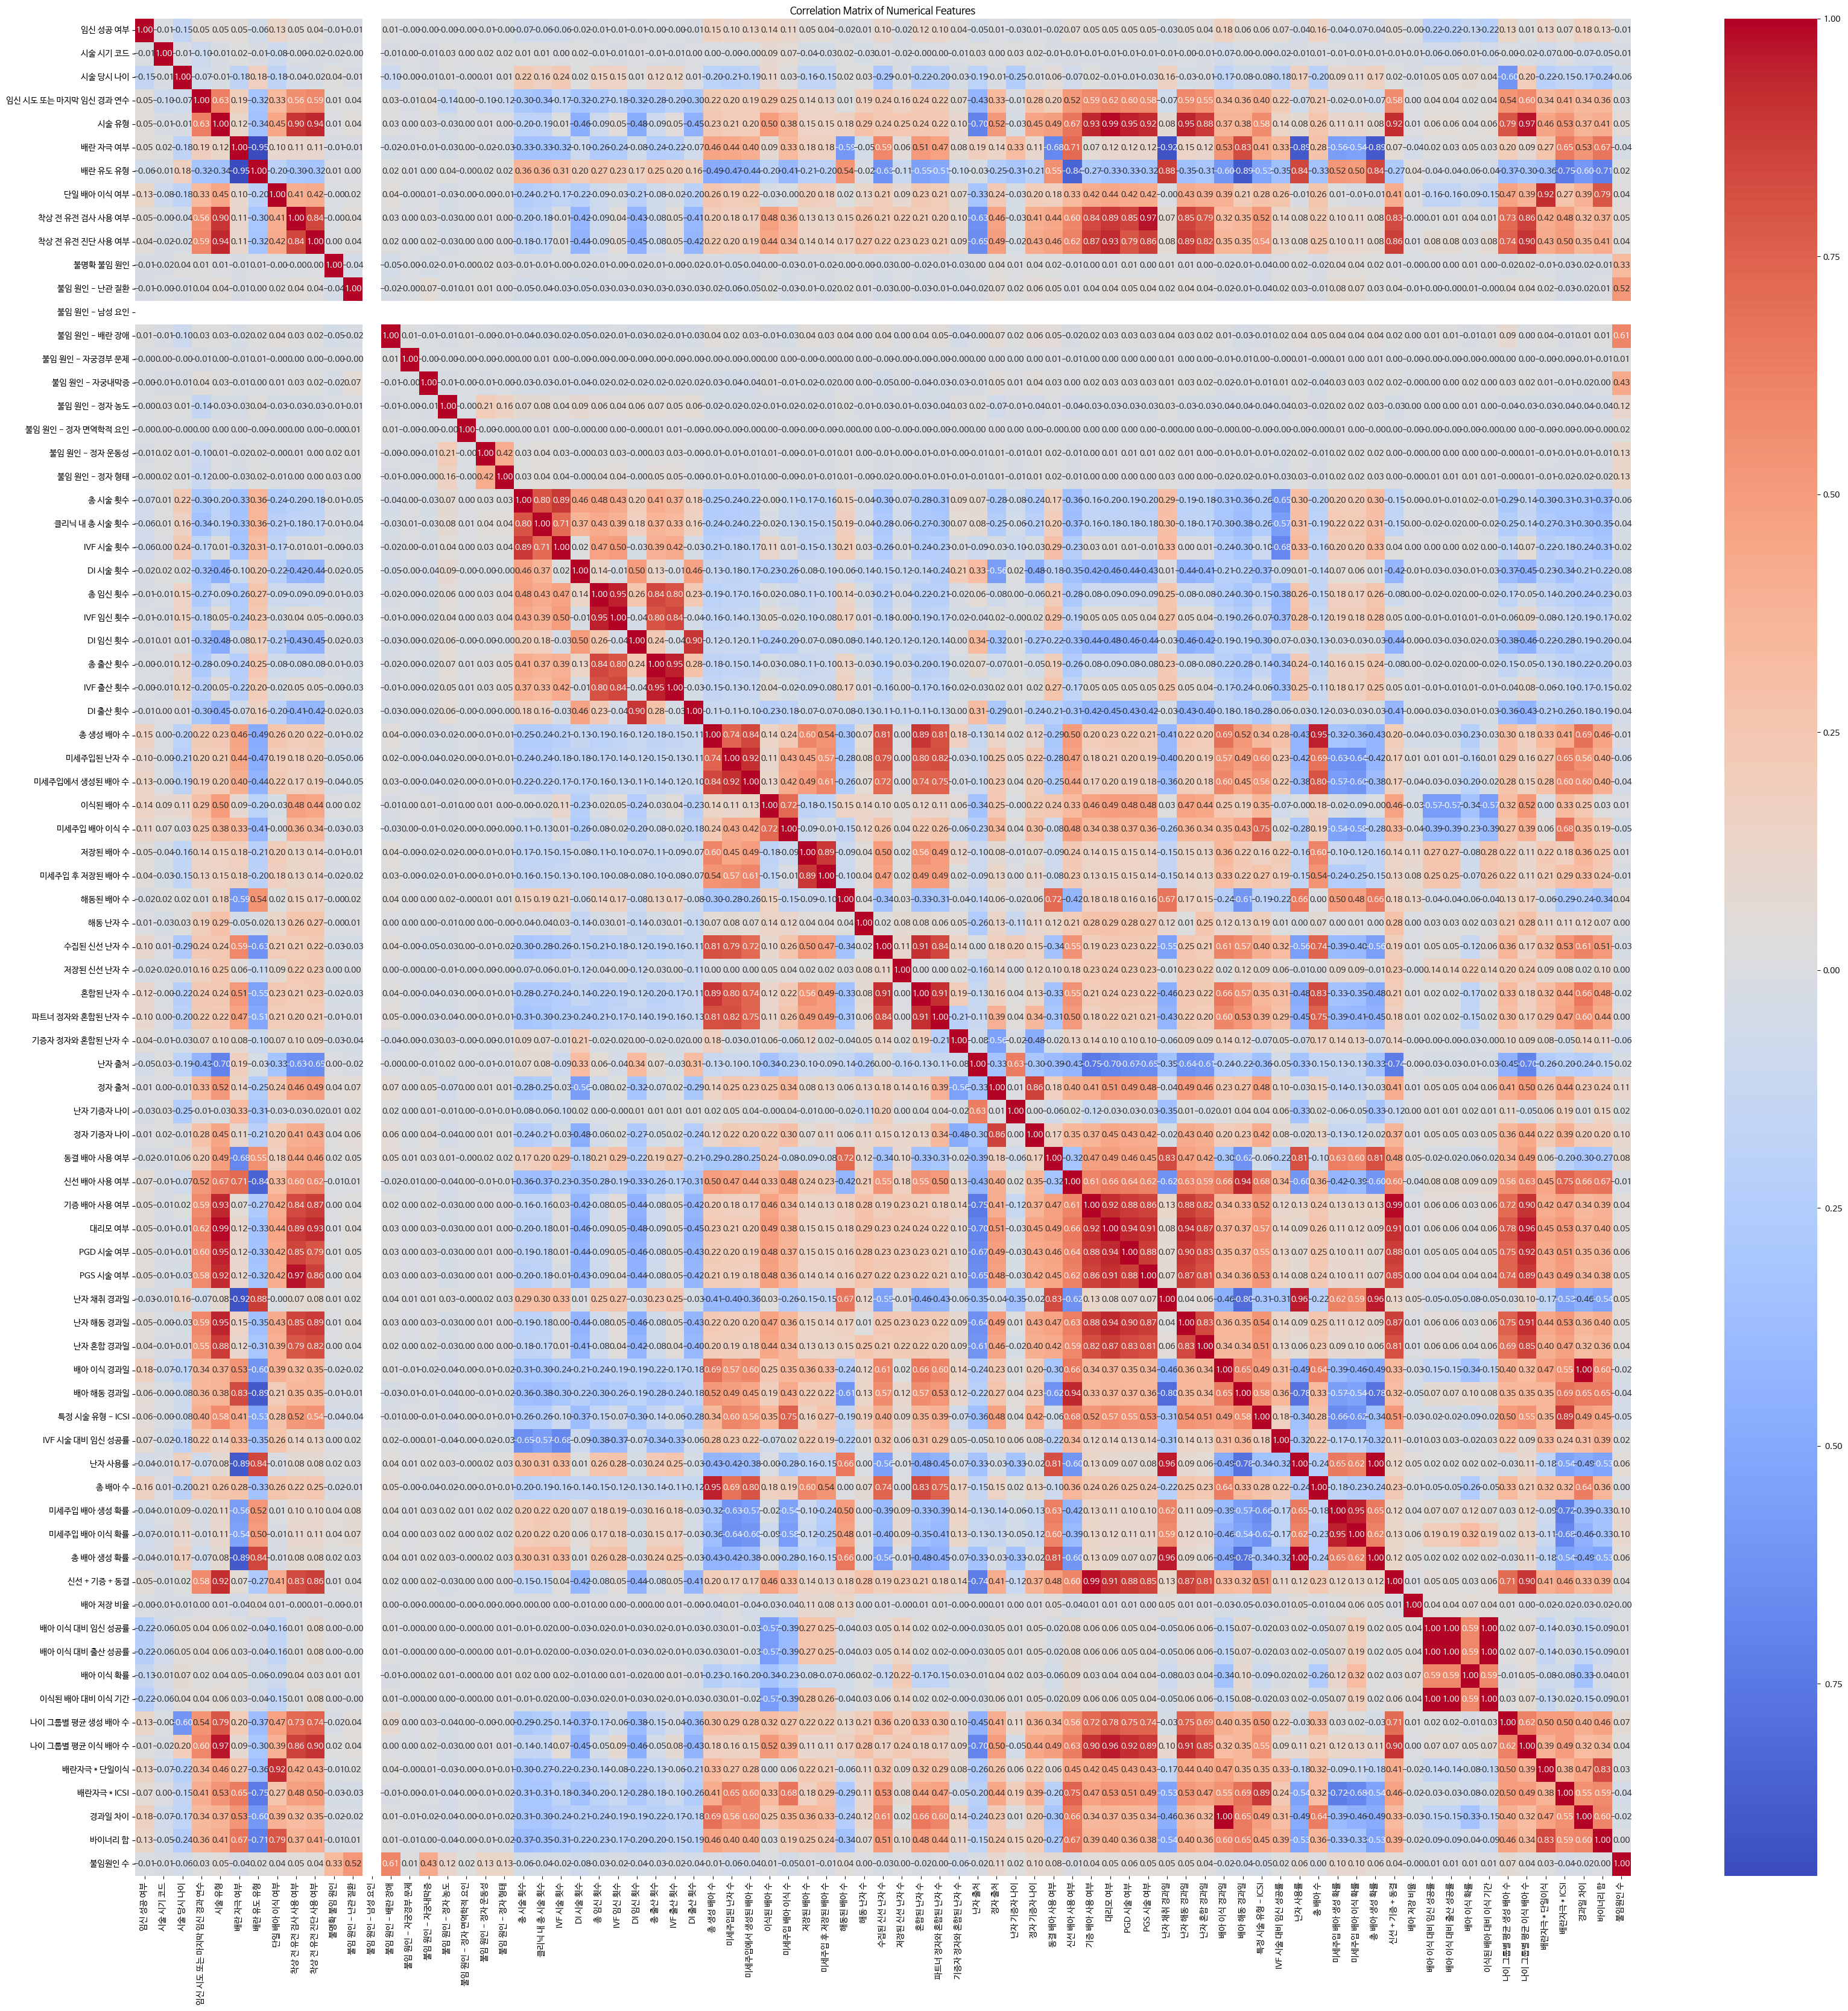

In [19]:
vis_numeric_corr_matrix(df_train[df_train['불임 원인 - 남성 요인'] == 1], type = 'all')

#### Scaling

In [20]:
# scaling_cols = [
#     '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', 
#     '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수',
#     '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수',
#     '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일',
#     '배아 이식 경과일', '경과일_차이', '불임원인_수', '배아저장비율', '이식된 배아 대비 이식 기간',
#     '총 배아 수', '나이 그룹별 평균 생성 배아 수', '나이 그룹별 평균 이식 배아 수', '나이 그룹별 평균 배아 이식 경과일'
# ]

# scaler = MinMaxScaler()
# df_train[scaling_cols] = scaler.fit_transform(df_train[scaling_cols])
# df_test[scaling_cols] = scaler.transform(df_test[scaling_cols])

### Modeling

In [21]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']
X_test = df_test

### Oversampling

In [35]:
from imblearn.over_sampling import BorderlineSMOTE
X,y= BorderlineSMOTE(random_state=123).fit_resample(X,y)

#### Stratified K-Fold 

In [36]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']} # Ensemble
feature_importances = {model: [] for model in ['CatBoost']}
test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # 모델 정의
    cat_model = CatBoostClassifier(
    iterations=745, 
    learning_rate=0.038577, 
    depth=8, 
    l2_leaf_reg=9.587765,
    subsample=0.748324, 
    random_strength=0.0,  # 0으로 설정
    min_data_in_leaf=59, 
    leaf_estimation_iterations=1, 
    loss_function='Logloss', 
    eval_metric='AUC', 
    verbose=100, 
    random_seed=123)

    # xgb_model = XGBClassifier(
    #     n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
    #     gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
    #     reg_lambda=1.0, verbosity=1, random_state=123
    # )

    # lgbm_model = LGBMClassifier(
    #     n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
    #     min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
    #     reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
    # )
    
    # adaboost_model = AdaBoostClassifier(
    #     estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
    #     n_estimators=500, learning_rate=0.05,
    #     algorithm="SAMME", random_state=123
    # )
    
#     ensemble_model = VotingClassifier(
#         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
#         voting='soft', weights=[1, 1, 1, 0.8]
#     )


    # 모델 학습
    for model in [cat_model]: # ensemble_model
#     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
        model.fit(X_train, y_train)

    # 평가 함수
    def evaluate_model(model, X_val, y_true):
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
        }

    # 평가 및 변수 중요도 저장
    for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

    for model_name, model in zip(['CatBoost'], [cat_model]):
        feature_importances[model_name].append(model.feature_importances_)
        
    # 테스트 데이터 예측 확률 저장
    test_proba['CatBoost'].append(cat_model.predict_proba(X_test)[:, 1])
#     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
#     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
#     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
#     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])


===== Fold 1 =====
0:	total: 19.9ms	remaining: 14.8s
100:	total: 2.04s	remaining: 13s
200:	total: 4.08s	remaining: 11s
300:	total: 6.03s	remaining: 8.9s
400:	total: 7.91s	remaining: 6.78s
500:	total: 9.79s	remaining: 4.76s
600:	total: 11.7s	remaining: 2.79s
700:	total: 13.5s	remaining: 848ms
744:	total: 14.3s	remaining: 0us
===== Fold 2 =====
0:	total: 19.2ms	remaining: 14.3s
100:	total: 2s	remaining: 12.7s
200:	total: 3.95s	remaining: 10.7s
300:	total: 5.87s	remaining: 8.66s
400:	total: 7.76s	remaining: 6.66s
500:	total: 9.61s	remaining: 4.68s
600:	total: 11.4s	remaining: 2.74s
700:	total: 13.2s	remaining: 827ms
744:	total: 14s	remaining: 0us
===== Fold 3 =====
0:	total: 19.5ms	remaining: 14.5s
100:	total: 1.97s	remaining: 12.6s
200:	total: 3.95s	remaining: 10.7s
300:	total: 5.91s	remaining: 8.72s
400:	total: 7.84s	remaining: 6.72s
500:	total: 9.67s	remaining: 4.71s
600:	total: 11.5s	remaining: 2.75s
700:	total: 13.3s	remaining: 833ms
744:	total: 14.1s	remaining: 0us
===== Fold 4 ====

In [37]:
# 평가 지표 평균 출력
print("===== Stratified K-Fold 평균 성능 =====")
for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.6f}")

===== Stratified K-Fold 평균 성능 =====

== CatBoost Model ==
Accuracy: 0.803801
Precision: 0.860026
Recall: 0.725720
F1 Score: 0.787184
ROC AUC Score: 0.895486


In [38]:
# 최종 변수 중요도 평균 계산
df_fi_list = []
for model_name, fi_list in feature_importances.items():
    avg_importance = np.mean(fi_list, axis=0)
    df_fi = pd.DataFrame({
        'Feature': X_train.columns,
        model_name: avg_importance 
    })
    df_fi = df_fi.sort_values(by=model_name, ascending=False).reset_index(drop=True)
    df_fi_list.append(df_fi)
    
df_fi_final = pd.concat(df_fi_list, axis=1)
df_fi_final

,Feature,CatBoost
0,나이 그룹별 평균 이식 배아 수,8.871907
1,저장된 배아 수,6.972990
2,이식된 배아 대비 이식 기간,6.506265
3,나이 그룹별 평균 생성 배아 수,6.316672
4,불임 원인 - 남성 요인,6.200916
...,...,...
73,PGD 시술 여부,0.000114
74,저장된 신선 난자 수,0.000031
75,불임 원인 - 정자 면역학적 요인,0.000000
76,시술 유형,0.000000


In [25]:
# # catboost 기준 변수 중요도 0.05 미만 변수 제거
# df_cat = df_fi_final.iloc[:, :2]
# df_selected = df_cat[df_cat['CatBoost'] > 0.05]
# selected_features = df_selected['Feature'].tolist()

# # 중요도가 높은 피처만 선택하여 새로운 데이터 생성
# X = X[selected_features]
# X_test = X_test[selected_features]

### Re-modeling

In [26]:
# # Stratified K-Fold 설정
# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

# metrics = {model: [] for model in ['CatBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost']}
# test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# # metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# # feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# # test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
#     print(f"===== Fold {fold} =====")

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # 모델 정의
#     cat_model = CatBoostClassifier(
#     iterations=745, 
#     learning_rate=0.038577, 
#     depth=8, 
#     l2_leaf_reg=9.587765,
#     subsample=0.748324, 
#     random_strength=0.0,  # 0으로 설정
#     min_data_in_leaf=59, 
#     leaf_estimation_iterations=1, 
#     loss_function='Logloss', 
#     eval_metric='AUC', 
#     verbose=100, 
#     random_seed=123)

#     # xgb_model = XGBClassifier(
#     #     n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
#     #     gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
#     #     reg_lambda=1.0, verbosity=1, random_state=123
#     # )

#     # lgbm_model = LGBMClassifier(
#     #     n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
#     #     min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
#     #     reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
#     # )
    
#     # adaboost_model = AdaBoostClassifier(
#     #     estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
#     #     n_estimators=500, learning_rate=0.05,
#     #     algorithm="SAMME", random_state=123
#     # )
    
# #     ensemble_model = VotingClassifier(
# #         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
# #         voting='soft', weights=[1, 1, 1, 0.8]
# #     )


#     # 모델 학습
#     for model in [cat_model]: # ensemble_model
# #     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
#         model.fit(X_train, y_train)

#     # 평가 함수
#     def evaluate_model(model, X_val, y_true):
#         y_pred = model.predict(X_val)
#         y_pred_proba = model.predict_proba(X_val)[:, 1]
        
#         # X_val의 이식된 배아 수가 0이면 y_pred_proba가 0이 되게 함
#         y_pred_proba = np.where(X_val['이식된 배아 수'] == 0, 0, y_pred_proba)

#         return {
#             'Accuracy': accuracy_score(y_true, y_pred),
#             'Precision': precision_score(y_true, y_pred),
#             'Recall': recall_score(y_true, y_pred),
#             'F1 Score': f1_score(y_true, y_pred),
#             'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
#         }

#     # 평가 및 변수 중요도 저장
#     for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
#         metrics[model_name].append(evaluate_model(model, X_val, y_val))

#     for model_name, model in zip(['CatBoost'], [cat_model]):
#         feature_importances[model_name].append(model.feature_importances_)
        
#     # 테스트 데이터 예측 확률 저장
#     # [ADD] 이식된 배아 수가 0이면 0으로 예측하도록 함.
#     y_test_proba = cat_model.predict_proba(X_test)[:, 1]
#     y_test_proba = np.where(X_test['이식된 배아 수'] == 0, 0, y_test_proba)
    
#     test_proba['CatBoost'].append(y_test_proba)
# #     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
# #     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
# #     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
# #     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])

In [27]:
# # 평가 지표 평균 출력
# print("===== Stratified K-Fold 평균 성능 =====")
# for model_name, model_metrics in metrics.items():
#     avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
#     print(f"\n== {model_name} Model ==")
#     for metric, value in avg_metrics.items():
#         print(f"{metric}: {value:.6f}")

### Prediction

In [28]:
# # Best AUC 기록한 모델의 pred_proba로 선택
# pred_proba = np.mean(test_proba['CatBoost'], axis=0)
# # pred_proba = np.mean(test_proba['XGBoost'], axis=0)
# # pred_proba = np.mean(test_proba['LightGBM'], axis=0)
# # pred_proba = np.mean(test_proba['AdaBoost'], axis=0)
# # pred_proba = np.mean(test_proba['Ensemble'], axis=0)

In [29]:
roc_auc_scores = np.array([fold_metrics['ROC AUC Score'] for fold_metrics in metrics['CatBoost']])

weights = roc_auc_scores / np.sum(roc_auc_scores)  # 합이 1이 되도록 정규화

test_proba_array = np.array(test_proba['CatBoost'])  # (n_folds, n_samples) 형태

pred_proba = np.average(test_proba_array, axis=0, weights=weights)

### Submission

In [30]:
# sample_submission = pd.read_csv('data/sample_submission.csv')
# sample_submission.head()

sample_submission = pd.read_csv(os.getenv('SUBMISSION_DATA_PATH'))
sample_submission.head()

,ID,probability
0,TEST_00000,0.0
1,TEST_00001,0.0
2,TEST_00002,0.0
3,TEST_00003,0.0
4,TEST_00004,0.0


In [31]:
# sample_submission['probability'] = pred_proba
# # 저장
# sample_submission.to_csv('data/submission.csv', index=False)
# sample_submission.head()

sample_submission['probability'] = pred_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}_{avg_metrics["ROC AUC Score"]:.5f}_eiden.csv')
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

,ID,probability
0,TEST_00000,0.002498
1,TEST_00001,0.003363
2,TEST_00002,0.145931
3,TEST_00003,0.115960
4,TEST_00004,0.493127


In [32]:
# 확인용
submission = pd.read_csv(save_path)
submission.head()

,ID,probability
0,TEST_00000,0.002498
1,TEST_00001,0.003363
2,TEST_00002,0.145931
3,TEST_00003,0.115960
4,TEST_00004,0.493127
